<h1 align="center"> The Five Best Retirement Locations in the United States 2021!</h1>

<img src="states.png"
     alt="s"
     width="550" 
     style="float: middle; margin-middle: 10px;" />
     
## I. Introduction
    The goal of this project is to find an adequate place to retire. In order to retire, there needs to be several characteristics to the aarea in which you decide to settle. In order to decide a place to retire, I decided to use state income tax and population density to narrow down my list of choices. According to 'random article' places with lower population density and lower taxes are better for retirement. Once picking my location based off these variables, i will use the foursquare api to determine if there are an adequate number of health facilities available per capita. In finding a place with low population density, low income tax, and large number of health facilities per capita, we will surely find an adequaate place to retire.

Shortcomings of this project:

    I am only performing an analysis on the city with the lowest population density and the lowest income tax rate. There are too many variable to perform an in depth analysis of all fifty states in addition to selecting the prime cities of each state... crime numbers, weather... some people like cold weather, some people dont plan to live year round, just make it official recidence.
    
---

## II. Data Cleaning

    This portion of the notebook is concerned with web-scraping information that will be needed to determine if a  location can be considered adequate for retirement

##### Imported Libraries

In [1]:
import pandas as pd
import requests

import matplotlib.pyplot as plt
import datetime

import numpy as np
from sklearn import preprocessing

import re

import geopy
import folium
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

%matplotlib inline

### 1. State Income Tax

        I began by filtering the states based on state income tax, where, the five states with the lowest income       
        tax rate will be used when picking our five best cities for retirement

In [2]:
url = 'https://en.wikipedia.org/wiki/State_income_tax'

df = pd.read_html(url)
df = pd.DataFrame(df[14])
df.head()

,State,Single Filer Rates > Brackets,Married Filing Jointly Rates > Brackets
0,Ala.,2.00%\t>\t$0,2.00%\t>\t$0
1,NaN,4.00%\t>\t$500,"4.00%\t>\t$1,000"
2,NaN,"5.00%\t>\t$3,000","5.00%\t>\t$6,000"
3,Alaska,none,none
4,Ariz.,2.59%\t>\t$0,2.59%\t>\t$0


#### i. Single Data Cleaning
            First we clean the single tax bracket column

In [3]:
df = df.fillna(method='ffill')

bracket = df['Single Filer Rates > Brackets'].str.split("$",n=2,expand=True)
bracket = bracket[[1]]
bracket = bracket.rename(columns={1:'[S] Tax Bracket ($)'})

tax = df['Single Filer Rates > Brackets'].str.split("%",n=1,expand=True)
tax = tax[[0]]
tax = tax.rename(columns={0:'[S] Income Tax Rate (%)'})

single = pd.concat([tax, bracket], axis=1)

#### ii. Married Data Cleaning

            Second we clean the married tax bracket column

In [4]:
bracket = df['Married Filing Jointly Rates > Brackets'].str.split("$",n=2,expand=True)
bracket = bracket[[1]]
bracket = bracket.rename(columns={1:'[M] Tax Bracket ($)'})

tax = df['Married Filing Jointly Rates > Brackets'].str.split("%",n=1,expand=True)
tax = tax[[0]]
tax = tax.rename(columns={0:'[M] Income Tax Rate (%)'})

married = pd.concat([tax, bracket], axis=1)

#### iii. Combine Data

            After cleaning the tax bracket columns, we concatenate them back into our original dataframe

In [5]:
df = pd.concat([df[['State']], single, married], axis=1)

df['[S] Tax Bracket ($)'] = df['[S] Tax Bracket ($)'].str.replace(',','')
df['[M] Tax Bracket ($)'] = df['[M] Tax Bracket ($)'].str.replace(',','')

df = df.replace('none',0)
df = df.fillna(value=0)

df = df.drop_duplicates(['State'],keep='first')

df['[S] Income Tax Rate (%)'] = df['[S] Income Tax Rate (%)'].astype(float)

df.head(10)

,State,[S] Income Tax Rate (%),[S] Tax Bracket ($),[M] Income Tax Rate (%),[M] Tax Bracket ($)
0,Ala.,2.00,0,2.00,0
3,Alaska,0.00,0,0,0
4,Ariz.,2.59,0,2.59,0
9,Ark.,0.90,0,0.90,0
15,Calif.,1.00,0,1.00,0
25,Colo.,4.63,0,4.63,0
26,Conn.,3.00,0,3.00,0
33,Del.,2.20,2000,2.20,2000
39,Fla.,0.00,0,0,0
40,Ga.,1.00,0,1.00,0


#### iv. Sort by lowest income tax rate

            After cleaning this dataset, we want to sort the income tax rate from lowest to highest, and pick those 
            states that have the lowest income tax rate

In [6]:
low_tax = df.sort_values(['[S] Income Tax Rate (%)'])
low_tax.head(5)

,State,[S] Income Tax Rate (%),[S] Tax Bracket ($),[M] Income Tax Rate (%),[M] Tax Bracket ($)
39,Fla.,0.0,0,0,0
3,Alaska,0.0,0,0,0
194,Wash.,0.0,0,0,0
125,Nev.,0.0,0,0,0
183,Tex.,0.0,0,0,0


---

These are the five states with the lowest income tax, being at 0%

Florida, Alaska, Washington, Nevada, and Texas, 

of these five states we now need to gather data on population size, population density, and latitude/longitude coordinates so that we may use the foursquare api later on to determine the number of healthcare facilities per capita

---

### 2. City Population / Population Density Data
    
    The following table lists the 317 incorporated places in the United States (excluding the U.S. territories) with a population of at least 100,000 on July 1, 2019, as estimated by the United States Census Bureau. Five states—Delaware, Maine, Vermont, West Virginia and Wyoming—have no cities with populations of 100,000 or more. The table below contains the following information:

    The city rank by population as of July 1, 2019, as estimated by the United States Census Bureau[1]
    The city name[1]
    The name of the state in which the city lies[1]
    The city population as of July 1, 2019, as estimated by the United States Census Bureau[1]
    The city population as of April 1, 2010, as enumerated by the 2010 United States Census[1]
    The city percent population change from April 1, 2010, to July 1, 2019
    The city land area as of January 1, 2016[2]
    The city population density as of July 1, 2016 (residents per unit of land area)[2]
    The city latitude and longitude coordinates[2]

In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'

df = pd.read_html(url)
df = pd.DataFrame(df[4])
df.head()

,2019rank,City,State[c],2019estimate,2010Census,Change,2016 land area,2016 land area.1,2016 population density,2016 population density.1,Location
0,1,New York City[d],New York,8336817,8175133,+1.98%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",".mw-parser-output .geo-default,.mw-parser-outp..."
1,2,Los Angeles,California,3979576,3792621,+4.93%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2693976,2695598,−0.06%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston[3],Texas,2320268,2100263,+10.48%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1680992,1445632,+16.28%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


#### City Population Data-Cleaning
    All we need from this data-set is the longitude and latitude of each city so that we can process it with the foursquare api, so we need to clean and restructure this data

#### i. Filter out unnecessary columns

In [8]:
df = df[['City', 'State[c]', '2019estimate', '2016 population density','Location']]
df = df.rename(columns={'State[c]':'State'})
df.head()

,City,State,2019estimate,2016 population density,Location
0,New York City[d],New York,8336817,"28,317/sq mi",".mw-parser-output .geo-default,.mw-parser-outp..."
1,Los Angeles,California,3979576,"8,484/sq mi",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,Chicago,Illinois,2693976,"11,900/sq mi",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,Houston[3],Texas,2320268,"3,613/sq mi",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,Phoenix,Arizona,1680992,"3,120/sq mi",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


#### ii. Longitude / Latitude of cities in United States

In [9]:
df_ll = df['Location'].str.split('/', n=1, expand = True)
df_ll = df_ll[1]
df_ll = df_ll.str.split(' ', n=2, expand = True)
df_ll

df_ll = df_ll.rename(columns={1:'Latitude'})
df_ll = df_ll.rename(columns={2:'Longitude'})

df_ll['Latitude'] = df_ll['Latitude'].str.replace('°N','')
df_ll['Longitude'] = df_ll['Longitude'].str.replace('°W','')

df_ll = df_ll.drop(columns=[0])

df_ll['Longitude'] = df_ll['Longitude'].astype(float)
df_ll['Longitude'] = df_ll['Longitude'] * -1

df_ll.head()

,Latitude,Longitude
0,﻿40.6635,-73.9387
1,﻿34.0194,-118.4108
2,﻿41.8376,-87.6818
3,﻿29.7866,-95.3909
4,﻿33.5722,-112.0901


#### iii. Merge cleaned latitude/longitude data with original dataset

In [10]:
df_new = pd.concat([df, df_ll], axis=1)
df_new = df_new.drop(columns=['Location'])
df_new.head()

,City,State,2019estimate,2016 population density,Latitude,Longitude
0,New York City[d],New York,8336817,"28,317/sq mi",﻿40.6635,-73.9387
1,Los Angeles,California,3979576,"8,484/sq mi",﻿34.0194,-118.4108
2,Chicago,Illinois,2693976,"11,900/sq mi",﻿41.8376,-87.6818
3,Houston[3],Texas,2320268,"3,613/sq mi",﻿29.7866,-95.3909
4,Phoenix,Arizona,1680992,"3,120/sq mi",﻿33.5722,-112.0901


#### iv. Clean the names of the cities

In [11]:
test = df_new['City'].str.split('[',n=1,expand=True)
test = test.rename(columns={0:'City'})
test = test[['City']]
df_new[['City']] = test
df_new.head()

city = df_new['City'].str.split(' City', n=1,expand=True)
city = city[[0]]
city = city.rename(columns={0:'City'})
df_new['City'] = city
df_new.head()

,City,State,2019estimate,2016 population density,Latitude,Longitude
0,New York,New York,8336817,"28,317/sq mi",﻿40.6635,-73.9387
1,Los Angeles,California,3979576,"8,484/sq mi",﻿34.0194,-118.4108
2,Chicago,Illinois,2693976,"11,900/sq mi",﻿41.8376,-87.6818
3,Houston,Texas,2320268,"3,613/sq mi",﻿29.7866,-95.3909
4,Phoenix,Arizona,1680992,"3,120/sq mi",﻿33.5722,-112.0901


#### v. Clean population density column

In [12]:
df_new['2016 population density'] = df_new['2016 population density'].str.replace(',','')

density = df_new['2016 population density'].str.split('/',n=1,expand=True)
density = density.rename(columns={0:'2016 population density'})
density = density[['2016 population density']]
density['2016 population density'] = density['2016 population density'].str.replace(' ', '', n=2)
density['2016 population density'] = density['2016 population density'].astype(int)

df_new['2016 population density'] = density
df_new.head()

,City,State,2019estimate,2016 population density,Latitude,Longitude
0,New York,New York,8336817,28317,﻿40.6635,-73.9387
1,Los Angeles,California,3979576,8484,﻿34.0194,-118.4108
2,Chicago,Illinois,2693976,11900,﻿41.8376,-87.6818
3,Houston,Texas,2320268,3613,﻿29.7866,-95.3909
4,Phoenix,Arizona,1680992,3120,﻿33.5722,-112.0901


#### vi. Sort dataframe by population density

In [13]:
df_new2 = df_new.sort_values(by=['2016 population density'],ascending=True)
df_new2 = df_new2.set_index('State')
df_new2.head()

,City,2019estimate,2016 population density,Latitude,Longitude
State,,,,,
Alaska,Anchorage,288000,175,﻿61.1743,-149.2843
Georgia,Macon,153159,612,﻿32.8088,-83.6942
Georgia,Augusta,197888,652,﻿33.3655,-82.0734
Oklahoma,Norman,124880,683,﻿35.2406,-97.3453
Virginia,Chesapeake,244835,703,﻿36.6794,-76.3018


#### vii. Filtering the population dataset by the 5 states with the lowest income tax rate

In [14]:
states = df_new2.loc[['Florida', 'Alaska', 'Washington', 'Nevada','Texas']].sort_values('2016 population density')
states = states.reset_index()
states = states.drop_duplicates(['State'],keep='first')
states = states.reset_index()
states = states[['City', 'State','2019estimate','2016 population density','Latitude','Longitude']]
states = states.rename(columns={'2019estimate':'Population', '2016 population density':'Population Density'})
states

,City,State,Population,Population Density,Latitude,Longitude
0,Anchorage,Alaska,288000,175,﻿61.1743,-149.2843
1,Abilene,Texas,123420,1146,﻿32.4545,-99.7381
2,Jacksonville,Florida,911507,1178,﻿30.3369,-81.6616
3,Reno,Nevada,255601,2286,﻿39.5491,-119.8499
4,Spokane Valley,Washington,101060,2681,﻿47.6733,-117.2394


---

Anchorage, Alaska is the city with the lowest population density as of 2016. Because Alaska is one of the five states with the lowest income tax rate, we will procede with an analysis to determine if the city is an adequate place for retirement

---

### 3. Zillow Data

I imported data from zillow into a csv file that shows the average house price of various cities in the United States.

Because this is an analysis to determine whether a city is an adequate place for retirement, we limited the housing data to family style housing units only, under the assumption that retirees will likely have family living either in the house or maybe in the area, as elderly individuals may require assistance from an additional helping hand

In [15]:
csv_path = '/Users/isaacshvartsman/Desktop/City_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv'

zillow = pd.read_csv(csv_path)
zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,1996-02-29,...,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30
0,6181,0,New York,City,NY,NY,New York-Newark-Jersey City,Queens County,207583.0,207009.0,...,665691.0,665820.0,666836.0,667437.0,668843.0,670446.0,673087.0,676000.0,678434.0,681484.0
1,12447,1,Los Angeles,City,CA,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,190758.0,190802.0,...,767433.0,774529.0,780670.0,783079.0,784686.0,791555.0,801350.0,812668.0,821201.0,829059.0
2,39051,2,Houston,City,TX,TX,Houston-The Woodlands-Sugar Land,Harris County,95357.0,95457.0,...,194185.0,195102.0,196259.0,197262.0,198020.0,198903.0,199942.0,201655.0,203345.0,205490.0
3,17426,3,Chicago,City,IL,IL,Chicago-Naperville-Elgin,Cook County,136370.0,136234.0,...,244154.0,245060.0,245741.0,246529.0,247584.0,249342.0,251438.0,254236.0,257102.0,259535.0
4,6915,4,San Antonio,City,TX,TX,San Antonio-New Braunfels,Bexar County,96098.0,96063.0,...,190852.0,191503.0,191815.0,192344.0,192855.0,193712.0,194788.0,196143.0,197776.0,199466.0


In [16]:
zillow1 = zillow
zillow1 = zillow1[['RegionName','State','2020-11-30']]
zillow1 = zillow1.rename(columns={'RegionName':'City','2020-11-30':'Typical_Home_Value'})
zillow1 = zillow1.set_index(['City'])
zillow1.head()

,State,Typical_Home_Value
City,,
New York,NY,681484.0
Los Angeles,CA,829059.0
Houston,TX,205490.0
Chicago,IL,259535.0
San Antonio,TX,199466.0


In [17]:
house_prices = zillow1[['Typical_Home_Value', 'State']].loc[['Anchorage', 'Spokane Valley', 'Abilene', 'Reno', 'Jacksonville']]
house_prices = house_prices.reset_index()
house_prices = house_prices.set_index(['State'])
house_prices = house_prices.loc[['AK', 'TX','NV','WA','FL']]
house_prices = house_prices.drop_duplicates('City', keep='last')
house_prices = house_prices.reset_index()
house_prices = house_prices.drop(columns='State')
house_prices = house_prices.set_index(['City'])
house_prices = house_prices.sort_values('City')
house_prices

,Typical_Home_Value
City,
Abilene,145682.0
Anchorage,375448.0
Jacksonville,214595.0
Reno,442817.0
Spokane Valley,309564.0


The average price of a house in Anchorage is $375,448

---

### 4. Foursquare API

##### Credentials

In [18]:
CLIENT_ID = '2LOVOXVONB2ZLRMS1QQ5VLU54HMDBZWJ2TJXIHYCFNLYP4MR'
CLIENT_SECRET = '05JK4BOLZ1HWSAMEVHOHYUIOXSNEFUR01BQBOHLSW1M2ARSP'
ACCESS_TOKEN = 'N5GM3RAUKIRTVEH1FJCHBKTYBHHW5JEBHFZFZG3LGLJSHX4W'
VERSION = '20210118'
LIMIT = 60
search_query = 'Hospital'
radius = 50000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2LOVOXVONB2ZLRMS1QQ5VLU54HMDBZWJ2TJXIHYCFNLYP4MR
CLIENT_SECRET:05JK4BOLZ1HWSAMEVHOHYUIOXSNEFUR01BQBOHLSW1M2ARSP


#### Anchorage, Alaska

In [19]:
latitude = 61.1743
longitude = -149.2843

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

##### Convert json format into usable dataframe format

In [20]:
results = requests.get(url).json()

venues = results['response']['venues']

df = pd.DataFrame(venues)
df.head()

,id,name,location,categories,referralId,hasPerk
0,4bf57706e5eba593b1d12090,VCA Alaska Pet Care Animal Hospital,"{'address': '3900 Lake Otis Pkwy', 'lat': 61.1...","[{'id': '4d954af4a243a5684765b473', 'name': 'V...",v-1611029463,False
1,4b8ef79ff964a520c44133e3,JBER Hospital,"{'address': '5955 Zeamer Ave', 'lat': 61.23495...","[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1611029463,False
2,4d6469df897a224b29a920cf,Chester Valley Veterinary Hospital,"{'address': '1517 Muldoon Rd', 'lat': 61.20624...","[{'id': '4d954af4a243a5684765b473', 'name': 'V...",v-1611029463,False
3,4d7576b5a16b6ea8b5bcb857,VCA East Anchorage Animal Hospital,"{'address': '2639 Boniface Pkwy', 'lat': 61.19...","[{'id': '4d954af4a243a5684765b473', 'name': 'V...",v-1611029463,False
4,4b86b711f964a520299831e3,Alaska Regional Hospital,"{'address': '2801 Debarr Rd', 'crossStreet': '...","[{'id': '4bf58dd8d48988d104941735', 'name': 'M...",v-1611029463,False


##### Extract category type from each venue

In [21]:
filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
df_filtered = df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_filtered['categories'] = df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_filtered.columns = [column.split('.')[-1] for column in df_filtered.columns]

df_filtered

,name,categories,id
0,VCA Alaska Pet Care Animal Hospital,Veterinarian,4bf57706e5eba593b1d12090
1,JBER Hospital,Hospital,4b8ef79ff964a520c44133e3
2,Chester Valley Veterinary Hospital,Veterinarian,4d6469df897a224b29a920cf
3,VCA East Anchorage Animal Hospital,Veterinarian,4d7576b5a16b6ea8b5bcb857
4,Alaska Regional Hospital,Medical Center,4b86b711f964a520299831e3
5,Children’s Hospital at Providence PICU,Hospital Ward,4d312696329e54818c1aa41d
6,The Children's Hospital at Providence,Hospital,4c684802d9c7c9b6ea0ac41a
7,Diamond Animal Hospital & Emergency Services,Veterinarian,4b52b360f964a5204a8627e3
8,Ascension Eagle River Hospital,Hospital,5adfa7f2178a2a1d9d9225f0
9,VCA Eagle River Animal Hospital,Veterinarian,4c1936a24ff90f47e0960f49


##### Filter out all categories that are not relative to health care

In [22]:
df = df_filtered.set_index('categories')
df.drop(index='Office', inplace = True)
df.drop(index='Veterinarian', inplace = True)
df.drop(index='Building', inplace = True)
df.drop(index='Coffee Shop', inplace = True)
df.drop(index='Non-Profit', inplace = True)
df.drop(index='Gift Shop', inplace = True)
df.drop(index='Pharmacy', inplace = True)

alaska = df

alaska = alaska[~alaska.name.str.contains("Children")]
alaska = alaska[~alaska.name.str.contains("Animal")]

print('Number of health care facilities in Anchorage, Alaska:',len(alaska))

alaska.head()

Number of health care facilities in Anchorage, Alaska: 21


,name,id
categories,,
Hospital,JBER Hospital,4b8ef79ff964a520c44133e3
Medical Center,Alaska Regional Hospital,4b86b711f964a520299831e3
Hospital,Ascension Eagle River Hospital,5adfa7f2178a2a1d9d9225f0
Hospital,Alaska Department Of Veterans Affairs - VA Hos...,4c096a76009a0f4705bbe7bf
Emergency Room,JBER Hospital ER,4d6c198b71d3721e0a0a9a06


---

now we repeat this process with the remaining locations that we have picked to explore

---

#### Abilene, Texas

In [23]:
latitude = 32.4545
longitude = -99.7381

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

In [24]:
results = requests.get(url).json()

venues = results['response']['venues']

df = pd.DataFrame(venues)

In [25]:
filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
df_filtered = df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_filtered['categories'] = df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_filtered.columns = [column.split('.')[-1] for column in df_filtered.columns]

In [26]:
df = df_filtered.set_index('categories')
df.drop(index='Veterinarian', inplace = True)
df.drop(index='Pet Service', inplace = True)
df.drop(index='Electronics Store', inplace = True)

texas = df

texas = texas[~texas.name.str.contains("Children")]

print('Number of health care facilities in Abilene, Texas:',len(texas))

texas.head()

Number of health care facilities in Abilene, Texas: 12


,name,id
categories,,
Hospital,Oceans Behavioral Hospital Abilene,5a8611e71de7652538487486
Doctor's Office,"Hendrick Center for Rehabilitation, Inpatient ...",5d793e2ed133420008d9c6f0
Hospital,Encompass Health Rehabilitation Hospital of Ab...,57dafbe1498e32d8e40aee85
NaN,Hendricks Hospital,4bd8722d0b779c74242d07a0
Rehab Center,Hendrick Center Rehabilitation & Therapy,5b586c8560255e002cb4dd73


#### Jacksonville, Florida

In [27]:
latitude = 30.3369
longitude = -81.6616

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

In [28]:
results = requests.get(url).json()

venues = results['response']['venues']

df = pd.DataFrame(venues)

In [29]:
filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
df_filtered = df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_filtered['categories'] = df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_filtered.columns = [column.split('.')[-1] for column in df_filtered.columns]

In [30]:
df = df_filtered.set_index('categories')
df.drop(index='Veterinarian', inplace = True)
df.drop(index='Mac & Cheese Joint', inplace = True)
df.drop(index='College Cafeteria', inplace = True)
df.drop(index='Church', inplace = True)
df.drop(index='Garden', inplace = True)
df.drop(index='Breakfast Spot', inplace = True)


florida = df

florida = florida[~florida.name.str.contains("Children")]

print('Number of health care facilities in Jacksonville, Florida:',len(florida))

florida.head()

Number of health care facilities in Jacksonville, Florida: 22


,name,id
categories,,
Hospital,Heart Hospital At Downtown Baptist,4d1c8e444ff98cfa597dbc3e
Hospital,Onslow Memorial Hospital,4e70ba90c65b340cde873991
Medical Center,Memorial Hospital Jacksonville,4b5f678ff964a5206cb829e3
Hospital,E K G Baptist Hospital,4f5fcc3fe4b0d13cc4dfa933
Hospital,Howard Building At Baptist Hospital,4c1f6a7b8b3aa5932f669d5f


---

#### Reno, Nevada

In [31]:
latitude = 39.5491
longitude = -119.8499

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

In [32]:
results = requests.get(url).json()

venues = results['response']['venues']

df = pd.DataFrame(venues)

In [33]:
filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
df_filtered = df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_filtered['categories'] = df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_filtered.columns = [column.split('.')[-1] for column in df_filtered.columns]

In [34]:
df = df_filtered.set_index('categories')
df.drop(index='Veterinarian', inplace = True)
df.drop(index='Automotive Shop', inplace = True)
df.drop(index='Animal Shelter', inplace = True)
df.drop(index='Arts & Crafts Store', inplace = True)
df.drop(index='Other Nightlife', inplace = True)
df.drop(index='Building', inplace = True)
df.drop(index='Health & Beauty Service', inplace = True)
df.drop(index='Burrito Place', inplace = True)
df.drop(index='Office', inplace = True)
df.drop(index='Pet Service', inplace = True)
df.drop(index='Music Store', inplace = True)


nevada = df
nevada = nevada[~nevada.name.str.contains("Animal")]
nevada = nevada[~nevada.name.str.contains("animal")]
nevada = nevada[~nevada.name.str.contains("Children")]
nevada = nevada[~nevada.name.str.contains("Vet")]

print('Number of health care facilities in Reno, Nevada:',len(nevada))

nevada.head()

Number of health care facilities in Reno, Nevada: 10


,name,id
categories,,
Hospital,Renown Health - Rehabilitation Hospital,4d190cbb81cea35dce20f2ec
Hospital,West Hills Hospital,4e692f96ae6037916d8d317b
NaN,"St. Mary's Hospital, Reno NV",53f9502c498e9dac1e32f4cc
Hospital,PAM Specialty Hospital of Sparks,5dc5eb9eb76cb700084bc537
Hospital,West Hills Hospital,4e1491f7d22d401417191402


---

#### Spokane, Washington

In [35]:
latitude = 47.6733
longitude = -117.2394

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

In [36]:
results = requests.get(url).json()

venues = results['response']['venues']

df = pd.DataFrame(venues)

In [37]:
filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
df_filtered = df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_filtered['categories'] = df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_filtered.columns = [column.split('.')[-1] for column in df_filtered.columns]

In [38]:
df = df_filtered.set_index('categories')
df.drop(index='Veterinarian', inplace = True)
df.drop(index='Pharmacy', inplace = True)
df.drop(index='Bank', inplace = True)
df.drop(index='Building', inplace = True)
df.drop(index='Food', inplace = True)


washington = df
washington = washington[~washington.name.str.contains("Animal")]
washington = washington[~washington.name.str.contains("animal")]
washington = washington[~washington.name.str.contains("Children")]
washington = washington[~washington.name.str.contains("Vet")]

print('Number of health care facilities in Spokane, Washington:',len(washington))

washington.head()

Number of health care facilities in Spokane, Washington: 13


,name,id
categories,,
Hospital,​MultiCare Valley Hospital,5b06fa97db2aeb0039dedf78
Medical Center,MultiCare Valley Hospital Family Birth Center,5de6dcd7a1452600087e43e0
Hospital,Holy Family Hospital,4ce594cde888f04de524316b
Hospital,Providence Holy Family Hospital,4c166bd6b7b9c928666dae37
Hospital,Sacred Heart Hospital CICU,5bec99439ef8ef002c48d0f1


---

#### Health Care Facilities per capita 

In [39]:
print('Population of:',states.iloc[0].City,',', states.iloc[0].State,'         :',states.iloc[0].Population)
print('              ',states.iloc[1].City,',', states.iloc[1].State,'            :',states.iloc[1].Population)
print('              ',states.iloc[2].City,',', states.iloc[2].State,'     :',states.iloc[2].Population)
print('              ',states.iloc[3].City,',', states.iloc[3].State,'              :',states.iloc[3].Population)
print('              ',states.iloc[4].City,',', states.iloc[4].State,':',states.iloc[4].Population)

Population of: Anchorage , Alaska          : 288000
               Abilene , Texas             : 123420
               Jacksonville , Florida      : 911507
               Reno , Nevada               : 255601
               Spokane Valley , Washington : 101060


In [40]:
print('Number of Health Care Facilities in:',states.iloc[0].City,',', states.iloc[0].State, '         :',len(alaska))
print('                                    ',states.iloc[1].City,',', states.iloc[1].State,'            :', len(texas))
print('                                    ',states.iloc[2].City,',', states.iloc[2].State,'     :', len(florida))
print('                                    ',states.iloc[3].City,',', states.iloc[3].State,'              :', len(nevada))
print('                                    ',states.iloc[4].City,',', states.iloc[4].State,':', len(washington))

Number of Health Care Facilities in: Anchorage , Alaska          : 21
                                     Abilene , Texas             : 12
                                     Jacksonville , Florida      : 22
                                     Reno , Nevada               : 10
                                     Spokane Valley , Washington : 13


In [41]:
print('Health Care Facilities per 100,000 people:',states.iloc[0].City,',', states.iloc[0].State,'         :', (len(alaska) / states.iloc[0].Population)*100000)
print('                                          ',states.iloc[1].City,',', states.iloc[1].State,'            :', (len(texas) / states.iloc[1].Population)*100000)
print('                                          ',states.iloc[2].City,',', states.iloc[2].State,'     :', (len(florida) / states.iloc[2].Population)*100000)
print('                                          ',states.iloc[3].City,',', states.iloc[3].State,'              :', (len(nevada) / states.iloc[3].Population)*100000)
print('                                          ',states.iloc[4].City,',', states.iloc[4].State,':', (len(washington) / states.iloc[4].Population)*100000)

Health Care Facilities per 100,000 people: Anchorage , Alaska          : 7.291666666666667
                                           Abilene , Texas             : 9.722897423432181
                                           Jacksonville , Florida      : 2.4135854140450923
                                           Reno , Nevada               : 3.9123477607677595
                                           Spokane Valley , Washington : 12.863645359192558


In [42]:
print('Average House Price in:' , \
      states.iloc[0].City,',', states.iloc[0].State, '         :', house_prices.Typical_Home_Value.iloc[1])
print('                       ' , \
      states.iloc[1].City,',', states.iloc[1].State, '            :', house_prices.Typical_Home_Value.iloc[0])
print('                       ' , \
      states.iloc[2].City,',', states.iloc[2].State, '     :', house_prices.Typical_Home_Value.iloc[2])
print('                       ' , \
      states.iloc[3].City,',', states.iloc[3].State, '              :', house_prices.Typical_Home_Value.iloc[3])
print('                       ' , \
      states.iloc[4].City,',', states.iloc[4].State, ':', house_prices.Typical_Home_Value.iloc[4])

Average House Price in: Anchorage , Alaska          : 375448.0
                        Abilene , Texas             : 145682.0
                        Jacksonville , Florida      : 214595.0
                        Reno , Nevada               : 442817.0
                        Spokane Valley , Washington : 309564.0


---

In [43]:
facilities = [(len(alaska)), (len(texas)), (len(florida)), (len(nevada)), (len(washington))]
facilities = pd.DataFrame(facilities)
facilities = facilities.rename(columns={0:'Total Number of Health Facilities'})
facilities

,Total Number of Health Facilities
0,21
1,12
2,22
3,10
4,13


In [44]:
health_care = [((len(alaska) / states.iloc[0].Population)*100000),  \
               ((len(texas) / states.iloc[1].Population)*100000),   \
               ((len(florida) / states.iloc[2].Population)*100000), \
               ((len(nevada) / states.iloc[3].Population)*100000),  \
               ((len(washington) / states.iloc[4].Population)*100000)]
health_care = pd.DataFrame(health_care)
health_care = health_care.rename(columns={0:'Health Facilities per 100k'})
health_care

,Health Facilities per 100k
0,7.291667
1,9.722897
2,2.413585
3,3.912348
4,12.863645


In [46]:
total = pd.concat([states,health_care, facilities, ],axis=1)
total = total.set_index(['City'])
total = total.sort_values('City')
total = pd.concat([total, house_prices], axis=1)
total = total.sort_values('Health Facilities per 100k',ascending=False)
total = total[['State', \
               'Total Number of Health Facilities',\
               'Population', 'Population Density', \
               'Health Facilities per 100k', \
               'Typical_Home_Value', \
               'Latitude', \
               'Longitude']]
total

,State,Total Number of Health Facilities,Population,Population Density,Health Facilities per 100k,Typical_Home_Value,Latitude,Longitude
City,,,,,,,,
Spokane Valley,Washington,13,101060,2681,12.863645,309564.0,﻿47.6733,-117.2394
Abilene,Texas,12,123420,1146,9.722897,145682.0,﻿32.4545,-99.7381
Anchorage,Alaska,21,288000,175,7.291667,375448.0,﻿61.1743,-149.2843
Reno,Nevada,10,255601,2286,3.912348,442817.0,﻿39.5491,-119.8499
Jacksonville,Florida,22,911507,1178,2.413585,214595.0,﻿30.3369,-81.6616


---

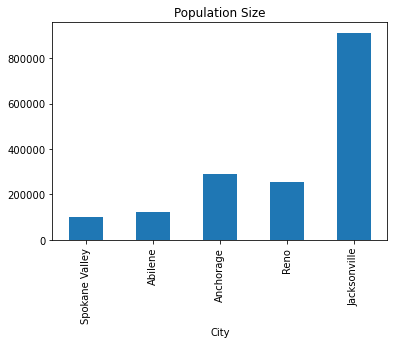

In [47]:
ax1 = total['Population'].plot(kind='bar')

ax1.set_title('Population Size')

pass

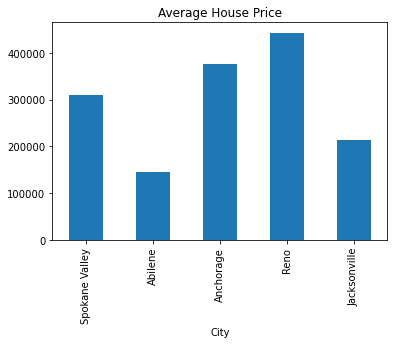

In [49]:
ax1 = total['Typical_Home_Value'].plot(kind='bar')

ax1.set_title('Average House Price')

pass

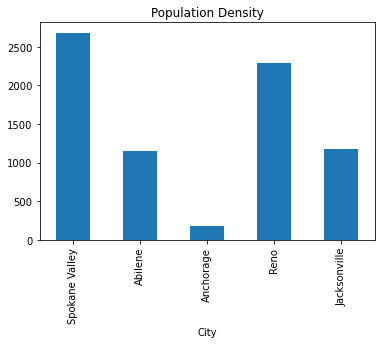

In [50]:
ax2 = total['Population Density'].plot(kind='bar')

ax2.set_title('Population Density')

pass

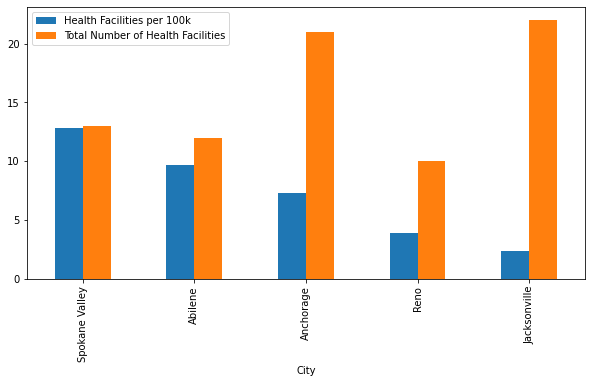

In [51]:
total[['Health Facilities per 100k','Total Number of Health Facilities']].plot(kind='bar', figsize=(10,5))

pass

---

## IV. Conclusion
    These are the 5 best places to retire, ranked from best to worst

### 1. Spokane Valley, Washington 

### 2. Abilene, Texas

### 3. Anchorage, Alaska

### 4. Reno, Nevada

### 5. Jacksonville, Florida

---

## V. Sources

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

https://en.wikipedia.org/wiki/State_income_tax/

https://www.zillow.com/research/data/

https://developer.foursquare.com/docs/

---

 #unorganized   
    
        1. break it down by state
            - state income tax
            - house price

        2. which city is the best for retirement?
        - proximity to airports
        - amount of hospitals
        - total population density
        - average house price of each city
    